In [1]:
%load_ext autoreload

%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session
from spikeA.Dat_file_reader import Dat_file_reader
from spikeA.Intervals import Intervals
from spikeA.Spike_train import Spike_train
from spikeA.Spike_waveform import Spike_waveform
from tqdm import tqdm
import os.path
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import spikeA.spatial_properties
import re

In [2]:
mouse="bt1021"
date="07012022"
name=f"{mouse}-{date}-0105"
path=f"/adata/electro/{mouse}/{name}/"

## Get a Session object and load spikes

In [3]:
ses = Kilosort_session(name=name,path=path)
ses.load_parameters_from_files()
print(ses)
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
cg = Cell_group(stl)

<class 'spikeA.Session.Kilosort_session'>
name = bt1021-07012022-0105
path = /adata/electro/bt1021/bt1021-07012022-0105
subject = bt1021
session_dat_time = 2022-01-07 01:05:00
fileBase = /adata/electro/bt1021/bt1021-07012022-0105/bt1021-07012022-0105
file_names = {'par': '/adata/electro/bt1021/bt1021-07012022-0105/bt1021-07012022-0105.par', 'desen': '/adata/electro/bt1021/bt1021-07012022-0105/bt1021-07012022-0105.desen', 'desel': '/adata/electro/bt1021/bt1021-07012022-0105/bt1021-07012022-0105.desel', 'sampling_rate': '/adata/electro/bt1021/bt1021-07012022-0105/bt1021-07012022-0105.sampling_rate_dat', 'stimulation': '/adata/electro/bt1021/bt1021-07012022-0105/bt1021-07012022-0105.stimulation', 'px_per_cm': '/adata/electro/bt1021/bt1021-07012022-0105/bt1021-07012022-0105.px_per_cm', 'params': '/adata/electro/bt1021/bt1021-07012022-0105/params.py', 'amplitudes': '/adata/electro/bt1021/bt1021-07012022-0105/amplitudes.npy', 'channel_map': '/adata/electro/bt1021/bt1021-07012022-0105/channel

## Create a pose file 

In [4]:
if os.path.exists(f"{path}{mouse}-{date}_01.positrack"):
    pose_extension="positrack"
elif os.path.exists(f"{path}{mouse}-{date}_01.trk"):
    pose_extension="trk"
else:
    print("Position tracking extension unknown")

ap = Animal_pose(ses)
if not os.path.exists(f"{ses.fileBase}.pose.npy"):
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50,extension=pose_extension)
    ap.save_pose_to_file() # save the file for next time
else:
    ap.load_pose_from_file()

## Limit analysis to a particular trial

You can get the time intervals for each trial from the session object.

* Get the time at which each trial starts and ends
* Set the intervals in the spike train object. 
* Set the intervals in the animal_pose object. 

In [5]:
print(ses.desen)
if re.search('0105$', str(name)):
    sqr70_indices = [i for i, j in enumerate(ses.desen) if j == 'sqr70']
    circ80_indices = [i for i, j in enumerate(ses.desen) if j == 'circ80']

    if ses.desen[0] == 'sqr70':
        first_trial_inter = ses.trial_intervals.inter[sqr70_indices[0:1],:] # first sqr70
        last_trial_inter = ses.trial_intervals.inter[sqr70_indices[-1:],:] # last sqr70
        middle_trial_inter = ses.trial_intervals.inter[circ80_indices[0:1],:] # first circ80
    else:
        first_trial_inter = ses.trial_intervals.inter[circ80_indices[0:1],:] # first circ
        last_trial_inter = ses.trial_intervals.inter[circ80_indices[-1:],:] # last circ
        middle_trial_inter = ses.trial_intervals.inter[sqr70_indices[0:1],:] # first sqr

    print(first_trial_inter)
    print(last_trial_inter)
    print(middle_trial_inter)
    
elif re.search('0107$', str(name)):
    first_trial_inter = ses.trial_intervals.inter[0:1,:] # no object
    second_trial_inter = ses.trial_intervals.inter[2:3,:] # object location1
    third_trial_inter = ses.trial_intervals.inter[4:5,:] # object location2
    forth_trial_inter = ses.trial_intervals.inter[6:7,:] # object location1
    
elif re.search('0109$', str(name)):
    first_trial_inter = ses.trial_intervals.inter[0:1,:] # no object
    second_trial_inter = ses.trial_intervals.inter[2:3,:] # object location1
    third_trial_inter = ses.trial_intervals.inter[4:5,:] # object location2
    forth_trial_inter = ses.trial_intervals.inter[6:7,:] # object location1
    fifth_trial_inter = ses.trial_intervals.inter[8:9,:] # object location1 + laser
else:
    print("Trial number unknown")

arena=[None]*len(ses.desen)
for n,en in enumerate(ses.desen):
    if re.search('sqr',str(ses.desen[n])):
         arena[n] = 'square'
    elif re.search('circ',str(ses.desen[n])):
        arena[n] = 'circle'
    else:
        arena[n] = ses.desen[n]
print(arena)    

stim_trial = [i for i, j in enumerate(ses.stimulation) if j == 'MS']
if stim_trial:
    stim_trial=stim_trial[0]
    print("Stim trial:", stim_trial+1) #counting the first trial as trial 1    

['sqr70', 'rb', 'circ80', 'rb', 'sqr70']
[[   0.      1246.39195]]
[[3785.508   5074.95595]]
[[1870.236   3130.66795]]
['square', 'rb', 'circle', 'rb', 'square']


Plot the interspike intervals to get an idea of theta rhythmicity.

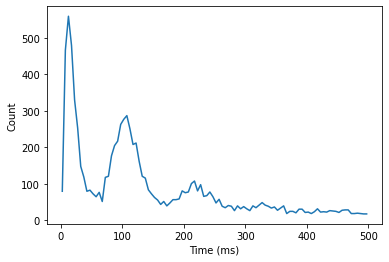

In [71]:
n=cg.neuron_list[5]
n.spike_train.inter_spike_intervals()
n.spike_train.inter_spike_intervals_histogram()
n.spike_train.inter_spike_interval_histogram_plot()

Get the spectrogram of the ifr.

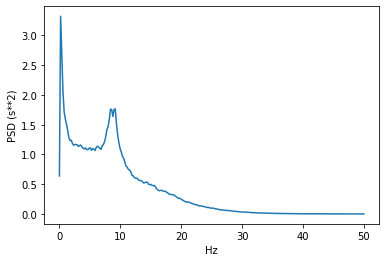

In [79]:
n.spike_train.instantaneous_firing_rate(bin_size_sec=0.01,sigma=1)
n.spike_train.instantaneous_firing_rate_power_spectrum()
n.spike_train.instantaneous_firing_rate_power_spectrum_plot()

Plot the spectrogram in the theta range.

(0.0, 20.0)

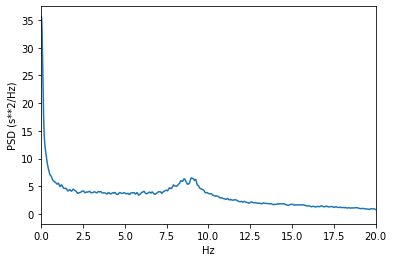

In [73]:
from scipy.ndimage import gaussian_filter1d
signal = gaussian_filter1d(n.spike_train.ifr_power_spectrum[1], sigma=200)
plt.plot(n.spike_train.ifr_power_spectrum[0], signal)
plt.xlabel("Hz")
plt.ylabel("PSD (s**2/Hz)")
plt.xlim([0,20])

We don't want to smooth with a sigma of 200. Try welch method instead.

In [74]:
from scipy.signal import welch
n.spike_train.instantaneous_firing_rate(bin_size_sec=0.01,sigma=1)
f,signal = welch(n.spike_train.ifr[0], fs=100, nperseg=2**9, scaling='spectrum')

(0.0, 20.0)

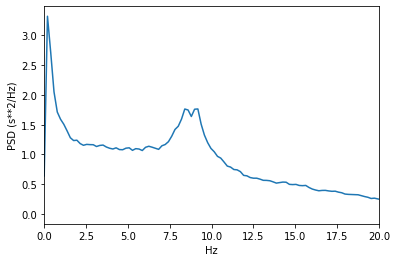

In [75]:
plt.plot(f, signal)
plt.xlabel("Hz")
plt.ylabel("PSD (s**2/Hz)")
plt.xlim([0,20])

In [76]:
def detect_theta_peak(f, signal, theta_range=[4,12], peak_range=[2,2], peak_height='90%theta_max', peak_distance='0.5Hz', sigma=1.5):
    """
        Method to find the peak frequency within theta range and calculate some theta properties
        
        Arguments:
        f: frequency (fft of time)
        signal: power (fft of signal)
        theta_range: range within the peak should be found
        peak_range: range around the peak which should be considered for theta power calculation and peak width calculation
        peak_height: required height for the peak to be detected
        peak_distance: required distance between detected peaks
        sigma: Gaussian kernel to smooth the signal before detecting the peak
        
        Return:
        theta peak frequency (in Hz), power at peak frequency, theta power, width at full height, width at half height 
    """
    
    import numpy as np
    from scipy.signal import find_peaks, peak_widths, peak_prominences
    from scipy import integrate
    from scipy.ndimage import gaussian_filter1d 
    print(np.max(signal))
    if sigma:
        signal = gaussian_filter1d(signal, sigma=sigma)
    print(np.max(signal))
    # cut the signal and frequency to the theta range
    theta_signal = [j for i,j in enumerate(signal) if f[i]>theta_range[0] and f[i]<theta_range[1]]
    theta_freq = [j for i,j in enumerate(f) if j>theta_range[0] and j<theta_range[1]]
    
    if peak_height == '90%theta_max':
        peak_height = np.max(theta_signal)*0.9
    if peak_distance == '0.5Hz':
        peak_distance = len(theta_freq)/(theta_range[1]-theta_range[0])/2
    
    # detect the theta peak
    peak = find_peaks(theta_signal, height=peak_height, distance=peak_distance)
    print(peak)
    # determine theta properties if peak was detected
    if peak[0].size>0:
        # select peak with highest power if several have been found
        if len(peak[0])>1:
            print('found more than 1 peak')
            max_power = np.nanmax([float(peak[1].get('peak_heights')[i]) for i,j in enumerate(peak[0])])
            peak_index_list = list(np.where([float(peak[1].get('peak_heights')[i]) for i,j in enumerate(peak[0])]==max_power))
            if len(peak_index_list[0])>1:
                peak_index_list[0] = peak_index_list[0][1:]
            peak_index = peak_index_list
            peak_freq_sample = peak[0][tuple(peak_index)]
            peak_power = float(peak[1].get('peak_heights')[tuple(peak_index)])
            peak_freq = theta_freq[int(peak[0][tuple(peak_index)])]
        else:
            peak_freq_sample = peak[0]
            peak_power = float(peak[1].get('peak_heights'))
            peak_freq = theta_freq[int(peak[0])]

        # calculate the prominence of the peak taking a window given by peak_range
        prominence_data = peak_prominences(theta_signal, peak_freq_sample, wlen=float((peak_range[0]+peak_range[1])*peak_freq_sample/(peak_freq-theta_range[0])))

        # get the width of the peak at full height and half height
        width_full = peak_widths(theta_signal, peak_freq_sample, prominence_data=prominence_data, rel_height=1)
        width_half = peak_widths(theta_signal, peak_freq_sample, prominence_data=prominence_data, rel_height=0.5)

        peak_width_full = (peak_freq-theta_range[0])/peak_freq_sample*width_full[0] #convert from sample to frequency
        peak_width_half = (peak_freq-theta_range[0])/peak_freq_sample*width_half[0]

        # to get the theta power, take the ratio of power around the theta peak and at lower and higher frequencies
        baseline1 = [peak_freq-2*peak_range[0],peak_freq-peak_range[0]]; baseline2 = [peak_freq+peak_range[1],peak_freq+2*peak_range[1]]
        theta = [peak_freq-peak_range[0],peak_freq+peak_range[1]]
        signal_baseline1 = [j for i,j in enumerate(signal) if f[i]>baseline1[0] and f[i]<baseline1[1]]
        f_baseline1 = [j for i,j in enumerate(f) if f[i]>baseline1[0] and f[i]<baseline1[1]]
        area_baseline1 = integrate.simpson(signal_baseline1, f_baseline1)

        signal_baseline2 = [j for i,j in enumerate(signal) if f[i]>baseline2[0] and f[i]<baseline2[1]]
        f_baseline2 = [j for i,j in enumerate(f) if f[i]>baseline2[0] and f[i]<baseline2[1]]
        area_baseline2 = integrate.simpson(signal_baseline2, f_baseline2)

        area_baseline = area_baseline1+area_baseline2

        signal_theta = [j for i,j in enumerate(signal) if f[i]>theta[0] and f[i]<theta[1]]
        f_theta = [j for i,j in enumerate(f) if f[i]>theta[0] and f[i]<theta[1]]
        area_theta = integrate.simpson(signal_theta, f_theta)

        theta_power = area_theta/area_baseline
    else:
        peak_freq = peak_power = theta_power = peak_width_full = peak_width_half = np.nan


    return (peak_freq, peak_power, theta_power, peak_width_full, peak_width_half)

In [77]:
(peak_freq, peak_power, range_power, peak_width_full, peak_width_half) = detect_theta_peak(f=f, signal=signal, sigma=1.5)
print((peak_freq, peak_power, range_power, peak_width_full, peak_width_half))

3.323083
2.2439575
(array([24]), {'peak_heights': array([1.70425534])})
(8.7890625, 1.7042553424835205, 1.6728131316837875, array([3.21433468]), array([1.71324299]))


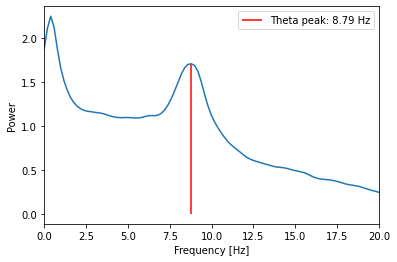

In [78]:
from scipy.ndimage import gaussian_filter1d
signal = gaussian_filter1d(signal, sigma=1.5)
plt.plot(f, signal)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.xlim([0,20])
label = f"Theta peak: {peak_freq:.3} Hz"
plt.vlines(peak_freq, ymin=0, ymax=peak_power, colors='red', label=label)
plt.legend()
plt.show()